# Robustness Study: Heloc Fico dataset
For this dataset, the target variable to predict is a binary variable called RiskPerformance. The value “Bad” indicates that a consumer was 90 days past due or worse at least once over a period of 24 months from when the credit account was opened. The value “Good” indicates that they have made their payments without ever being more than 90 days overdue. https://community.fico.com/s/explainable-machine-learning-challenge.

## Librairies 

In [1]:
import os, sys, time
import numpy as np
import pandas as pd

In [1]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [4]:
import torch 
import torch.nn as nn
import torch.optim as optim 

In [5]:
import pickle
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch.callbacks import EarlyStopping,LRScheduler,Checkpoint, TrainEndCheckpoint, EpochScoring
from skorch.dataset import Dataset
from skorch.helper import predefined_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
sys.path.append("../")
from sramodels.SRAModels import TabSRALinearClassifier,InputShapeSetterTabSRA,LinearClassifier

In [7]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [8]:
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor


In [9]:
from xgboost import XGBClassifier
import xgboost as xgb

/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [10]:
import shap

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

## Data loading, preprocessing and Split

In [12]:
data_path = '../ESANN_XKDD/Datasets/'
data = pd.read_csv(data_path+'heloc_dataset_v1.csv')
data["RiskPerformance"] =  np.where(data["RiskPerformance"]=='Bad',0,1)
data.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,0,55,144,4,84,20,3,0,83,2,3,5,23,1,43,0,0,0,33,-8,8,1,1,69
1,0,61,58,15,41,2,4,4,100,-7,0,8,7,0,67,0,0,0,0,-8,0,-8,-8,0
2,0,67,66,5,24,9,0,0,100,-7,7,8,9,4,44,0,4,4,53,66,4,2,1,86
3,0,66,169,1,73,28,1,1,93,76,6,6,30,3,57,0,5,4,72,83,6,4,3,91
4,0,81,333,27,132,12,0,0,100,-7,7,8,12,0,25,0,1,1,51,89,3,1,0,80


In [13]:
data.RiskPerformance.mean()

0.4780571756382063

### Preprocessing 

In [14]:
data_copy = data.copy()

In [15]:
feature_names = list(data.columns)
feature_names.remove('RiskPerformance')

### Split 

In [12]:
k =5
Sf= StratifiedKFold(n_splits=k, shuffle=True, random_state= 42)
#datasets = [(X[train_index], X[test_index],y[train_index], y[test_index]) for train_index,test_index in Sf.split(X, y) ]
datasets_raw = [(data.iloc[train_index], data.iloc[test_index]) for train_index,test_index in Sf.split(data, data.RiskPerformance.values) ]
data_train_df,data_test_df = datasets_raw[0]

In [13]:
data_train_df,data_test_df = datasets_raw[0]

In [14]:
X_train_, X_test_, Y_train_, Y_test_ = data_train_df[feature_names], data_test_df[feature_names],data_train_df.RiskPerformance.values,data_test_df.RiskPerformance.values

In [15]:
set_config(transform_output="pandas")
processor =  StandardScaler()

In [16]:
X_train_ = processor.fit_transform(X_train_)
X_test_ = processor.transform(X_test_)

### Correlation visualization (map)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [18]:
X_train_tmp = X_train_.copy()
X_train_tmp['y'] = Y_train_

/tmp/ipykernel_13896/1798339133.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


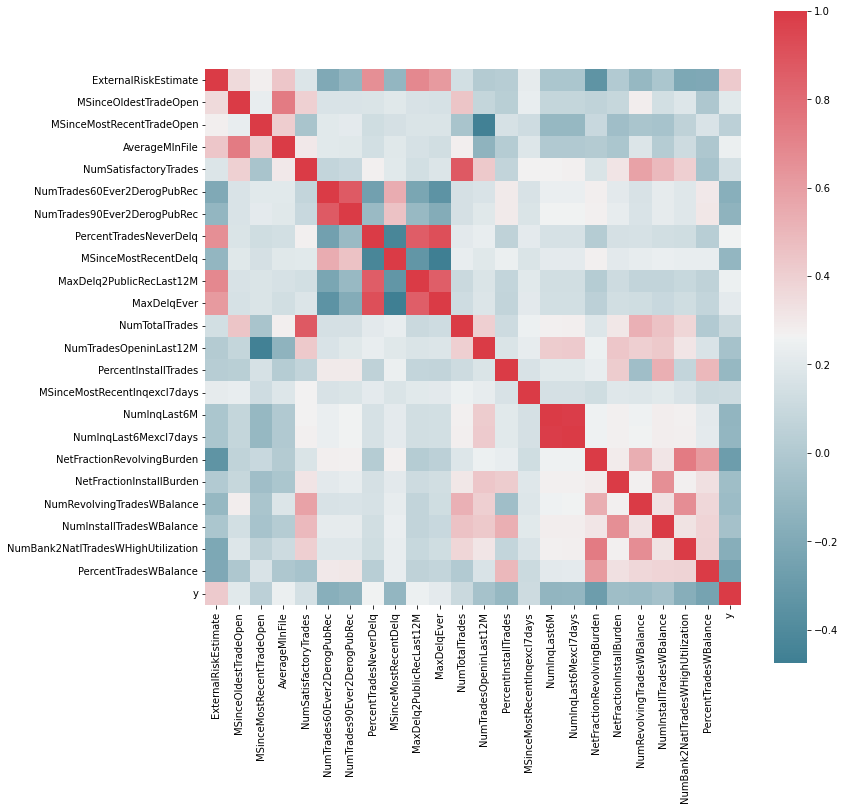

In [19]:
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 12))
tmp = X_train_tmp.astype(float) 
corr = tmp.corr(method='spearman')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

/tmp/ipykernel_13896/2226804073.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


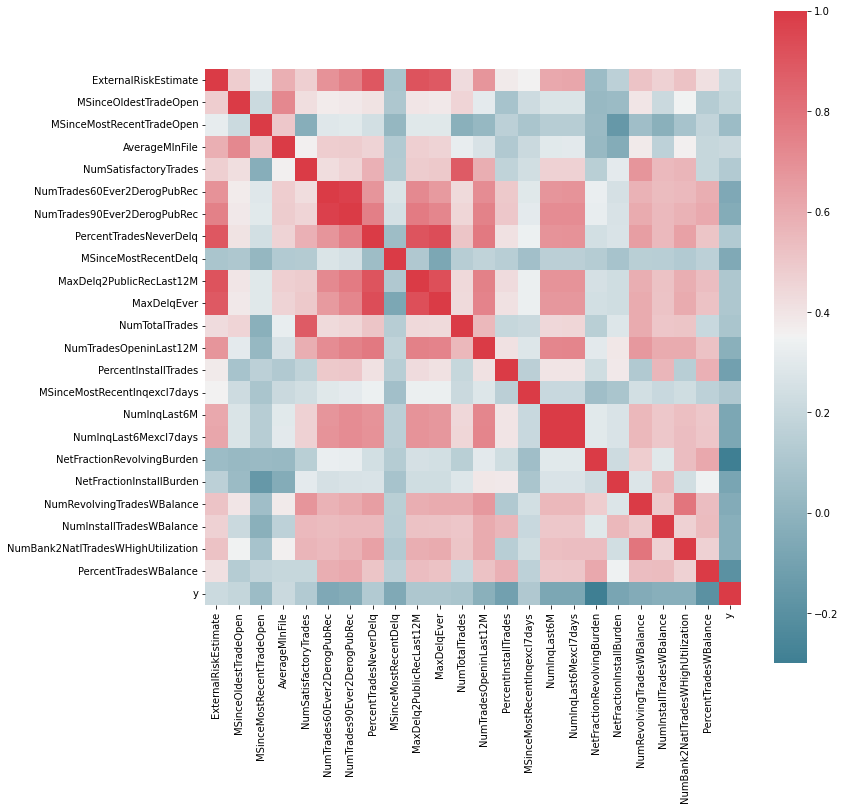

In [20]:
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 12))
tmp = X_train_tmp.astype(float) 
corr = tmp.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

## Model

### Linear  

In [21]:
#valid_loss
other_params_linear = {"module__bias":True,
                "optimizer__lr":0.007143256650213327,
                "optimizer__weight_decay":5.348330773994543e-06,
                "random_state":42,
                "criterion": nn.BCEWithLogitsLoss,
                "module__negative_indice":None,
                "module__positive_indice":None,
                "max_epochs":500,
                "batch_size":256,
                "device":'cuda'#change the device in 'cpu' if there is no GPU
               }
scoring = EpochScoring(scoring='roc_auc',lower_is_better=False)
setter = InputShapeSetterTabSRA(regression=False)
early_stop = EarlyStopping(monitor=scoring.scoring, patience=50,load_best=True,lower_is_better=False, threshold=0.0001,threshold_mode='abs')
lr_scheduler = LRScheduler(policy=ReduceLROnPlateau, patience=25, min_lr=2e-5,factor=0.2, verbose=1)
call_b = [scoring, setter, early_stop, lr_scheduler]

In [22]:
Y_test_.shape

(2092,)

In [23]:
%%time
valid_dataset = Dataset(X_test_.values.astype(np.float32),Y_test_.astype(np.float32))
LR = LinearClassifier(**other_params_linear,train_split = predefined_split(valid_dataset),callbacks = call_b)#,
_ = LR.fit(X_train_.values.astype(np.float32),Y_train_.astype(np.float32))

Re-initializing module because the following parameters were re-set: module__dim_input, module__dim_output.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.7447        0.6349       0.6840        0.5956  0.6451
      2     0.7680        0.5829       0.7012        0.5772  0.0590
      3     0.7725        0.5744       0.7094        0.5720  0.0583
      4     0.7750        0.5703       0.7098        0.5696  0.0554
      5     0.7771        0.5686       0.7122        0.5680  0.0595
      6     0.7773        0.5671       0.7118        0.5675  0.0600
      7     0.7776        0.5671       0.7113        0.5670  0.0607
      8     0.7792        0.5677       0.7137        0.5661  0.0602
      9     0.7768        0.5659       0.7103        0.5674  0.0597
     10     0.7791        0.5653       0.7127        0.5662  0.0580
     11     0.7754    

In [24]:
len(feature_names)

23

In [24]:
Coef  = pd.DataFrame(LR.get_weights()[0])
Coef = Coef
Coef.columns=feature_names
Coef

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,0.810069,0.057554,-0.134708,0.345282,0.370131,-0.319619,-0.280662,0.259453,-0.02527,0.24565,-0.24878,-0.027017,-0.089957,-0.260288,0.13948,-0.330407,-0.085133,-0.416432,-0.026475,-0.41397,0.08272,0.095416,-0.004345


In [25]:
# Inference on the test set. the Predict function will return the ouptut scores and the attention weights as Model.get_attention is True
pred_lr = LR.predict_proba(X_test_.values.astype(np.float32))[:,1]

best_aucroc_lr = roc_auc_score(Y_test_, pred_lr) 
best_aurpr_lr = average_precision_score(Y_test_, pred_lr) 
print(f"--AUCROC perf = {best_aucroc_lr} -- AUCPR perf = {best_aurpr_lr}")

--AUCROC perf = 0.7811135531135531 -- AUCPR perf = 0.7571985643576569


### TabSRA  

In [26]:
#valid_loss
other_params = {"module__encoder_bias":True,
                "module__classifier_bias":True,
                "module__n_head":1,
                "module__dim_head":8,
                "module__n_hidden_encoder":1,
                "module__dropout_rate":0.3,
                "optimizer__lr":0.009,#275745003824123,
                "optimizer__weight_decay":0.0004,#338871767939995,
                "random_state":42,
                "criterion": nn.BCEWithLogitsLoss,
                "module__negative_indice":None,
                "module__positive_indice":None,
                "max_epochs":500,
                "batch_size":1792,
                "device":'cuda'#change the device in 'cpu' if there is no GPU
               }
scoring = EpochScoring(scoring='roc_auc',lower_is_better=False)
setter = InputShapeSetterTabSRA(regression=False)
early_stop = EarlyStopping(monitor=scoring.scoring, patience=50,load_best=True,lower_is_better=False, threshold=0.0001,threshold_mode='abs')
lr_scheduler = LRScheduler(policy=ReduceLROnPlateau, patience=25, min_lr=2e-5,factor=0.2, verbose=1)
call_b = [scoring, setter, early_stop, lr_scheduler]

In [89]:
%%time
valid_dataset = Dataset(X_test_.values.astype(np.float32),Y_test_.astype(np.float32))
TabSRA = TabSRALinearClassifier(**other_params,train_split = predefined_split(valid_dataset),callbacks = call_b)#,
_ = TabSRA.fit(X_train_.values.astype(np.float32),Y_train_.astype(np.float32))

Re-initializing module because the following parameters were re-set: module__dim_input, module__dim_output.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.6811        0.6932       0.6233        0.6731  0.0614
      2     0.7341        0.6594       0.6721        0.6391  0.0559
      3     0.7431        0.6271       0.6821        0.6138  0.0492
      4     0.7539        0.6065       0.6898        0.5996  0.0493
      5     0.7625        0.5945       0.7012        0.5902  0.0527
      6     0.7706        0.5860       0.7051        0.5824  0.0487
      7     0.7742        0.5789       0.7089        0.5756  0.0462
      8     0.7784        0.5723       0.7141        0.5700  0.0524
      9     0.7806        0.5663       0.7165        0.5661  0.0470
     10     0.7825        0.5627       0.7156        0.5637  0.1106
     11     0.7851    

In [63]:
# Inference on the test set. the Predict function will return the ouptut scores and the attention weights as Model.get_attention is True
pred_tabsra = TabSRA.predict_proba(X_test_.values.astype(np.float32))[:,1]

best_aucroc = roc_auc_score(Y_test_, pred_tabsra) 
best_aurpr = average_precision_score(Y_test_, pred_tabsra) 
print(f"--AUCROC perf = {best_aucroc} -- AUCPR perf = {best_aurpr}")

--AUCROC perf = 0.7947014652014652 -- AUCPR perf = 0.7753445622806545


In [28]:
Coef  = pd.DataFrame(TabSRA.get_weights()[0])
Coef = Coef.T
Coef.columns=feature_names
Coef

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,1.611713,0.144753,-0.2851,1.447543,0.918009,-0.210805,-0.08536,1.79208,0.396699,0.863246,-0.022624,-0.061059,0.152821,-0.725277,0.896041,-0.773791,-0.218277,-1.111185,-0.157643,-1.151793,0.170946,0.030289,0.057035


### XGBoost

In [30]:
static_params = {
                 'random_state':42,
                 'objective': 'binary:logistic',
                 'n_jobs': -1,
                 #'base_score':y.mean()

}

params = {'eta': 0.0054836062607363095, 'max_depth': 4, 'colsample_bytree': 1.0, 'subsample': 0.8, 'n_estimators': 1100, 'min_child_weight': 22}



params.update(static_params)

In [31]:
model_xgb = XGBClassifier(**params)

In [34]:
eval_set = [(X_train_.values, Y_train_), (X_test_.values, Y_test_)] #(X_train, Y_train[:,1]), 
model_xgb.fit(X_train_.values, Y_train_, eval_metric=['auc'], eval_set=eval_set, verbose=0,early_stopping_rounds=100)

/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eta=0.0054836062607363095, gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.00548360636, max_delta_step=0, max_depth=4,
              min_child_weight=22, missing=nan, monotone_constraints='()',
              n_estimators=1100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [35]:
pred_xgb = model_xgb.predict_proba(X_test_)[:,1]
best_aucroc_xgb = roc_auc_score(Y_test_, pred_xgb) 
best_aurpr_xgb = average_precision_score(Y_test_, pred_xgb) 
print(f"--AUCROC perf = {best_aucroc_xgb} -- AUCPR perf = {best_aurpr_xgb}")

--AUCROC perf = 0.7976245421245421 -- AUCPR perf = 0.7814848170562338


### EBM

In [37]:
ExplainableBoostingClassifier(interactions=10,max_rounds=20000,early_stopping_rounds=50,inner_bags=25,outer_bags=100,n_jobs=-1)

ExplainableBoostingClassifier(inner_bags=25, max_rounds=20000, n_jobs=-1,
                              outer_bags=100)

In [38]:
%%time
EBM_S = ExplainableBoostingClassifier(interactions=0,max_rounds=20000,early_stopping_rounds=50,inner_bags=25,outer_bags=100,n_jobs=-1)#max_bins=256#,inner_bags=100,outer_bags=100 # 10
EBM_S.fit(X_train_, Y_train_)

CPU times: user 309 ms, sys: 320 ms, total: 628 ms
Wall time: 22.9 s


ExplainableBoostingClassifier(inner_bags=25, interactions=0, max_rounds=20000,
                              n_jobs=-1, outer_bags=100)

In [39]:
pred_ebm_s = EBM_S.predict_proba(X_test_)[:,1]
best_aucroc_ebm_s = roc_auc_score(Y_test_, pred_ebm_s) 
best_aurpr_ebm_s = average_precision_score(Y_test_, pred_ebm_s) 
print(f"--AUCROC perf = {best_aucroc_ebm_s} -- AUCPR perf = {best_aurpr_ebm_s}")

--AUCROC perf = 0.7950137362637363 -- AUCPR perf = 0.7775959851942762


In [41]:
%%time
EBM = ExplainableBoostingClassifier(interactions=10,max_rounds=20000,early_stopping_rounds=50,inner_bags=25,outer_bags=100,n_jobs=-1)#max_bins=256#,inner_bags=100,outer_bags=100 # 10
EBM.fit(X_train_, Y_train_)

CPU times: user 869 ms, sys: 35.6 ms, total: 905 ms
Wall time: 43.3 s


ExplainableBoostingClassifier(inner_bags=25, max_rounds=20000, n_jobs=-1,
                              outer_bags=100)

In [42]:
pred_ebm = EBM.predict_proba(X_test_)[:,1]
best_aucroc_ebm = roc_auc_score(Y_test_, pred_ebm) 
best_aurpr_ebm = average_precision_score(Y_test_, pred_ebm) 
print(f"--AUCROC perf = {best_aucroc_ebm} -- AUCPR perf = {best_aurpr_ebm}")

--AUCROC perf = 0.7982097069597069 -- AUCPR perf = 0.7826232899324753


## Explanations

In [64]:
%%time
attributions_linear = pd.DataFrame(LR.get_feature_attribution(X_test_.values))
attributions_linear.columns = feature_names
attributions_linear['pred_proba'] = pred_lr
attributions_linear['label'] = Y_test_

CPU times: user 67.5 ms, sys: 253 µs, total: 67.7 ms
Wall time: 5.8 ms


In [65]:
%%time
attributions_tabsra = pd.DataFrame(TabSRA.get_feature_attribution(X_test_.values))
attributions_tabsra.columns = feature_names
attributions_tabsra['pred_proba'] = pred_tabsra
attributions_tabsra['label'] = Y_test_

CPU times: user 45.6 ms, sys: 922 µs, total: 46.5 ms
Wall time: 5.06 ms


In [66]:
%%time
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test_)
attributions_xgb = pd.DataFrame(shap_values.values)
attributions_xgb.columns = feature_names
attributions_xgb['pred_proba'] = pred_xgb
attributions_xgb['label'] = Y_test_

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CPU times: user 5.13 s, sys: 4.15 ms, total: 5.13 s
Wall time: 626 ms


In [67]:
def get_feature_attribution_EBM(model, X_test):
    tmp  = model.explain_local(X_test)
    df_EBM = []
    for i in range(len(X_test)):
        df_EBM.append(tmp.data(i)['scores'])
    df_EBM = pd.DataFrame(df_EBM)
    df_EBM.columns = tmp.data(0)['names']
    return df_EBM

In [68]:
attributions_EBM_S = get_feature_attribution_EBM(EBM_S, X_test_)


In [69]:
%%time
attributions_EBM_S = get_feature_attribution_EBM(EBM_S, X_test_)
feature_names_EBM_S = list(attributions_EBM_S.columns)
attributions_EBM_S['pred_proba'] = pred_ebm_s
attributions_EBM_S['label'] = Y_test_

CPU times: user 74.9 ms, sys: 7.91 ms, total: 82.8 ms
Wall time: 81.1 ms


In [70]:
%%time
attributions_EBM = get_feature_attribution_EBM(EBM, X_test_)
feature_names_EBM = list(attributions_EBM.columns)
attributions_EBM['pred_proba'] = pred_ebm
attributions_EBM['label'] = Y_test_

CPU times: user 84.9 ms, sys: 8.04 ms, total: 93 ms
Wall time: 91.1 ms


In [71]:
# sample random observations
np.random.seed(42)
random_ = np.random.randn(len(X_test_))
sample_condition = np.where(random_>0, True, False)
sample_condition.sum()

1076

In [72]:
X_test_tmp = X_test_[sample_condition]

In [73]:
alpha_stp = 1e-2
n_pertub = 100
epsilon_min = 1e-3
n_features = len(feature_names)

In [74]:
np.random.seed(42)
tmp_x =np.random.normal(0,1*alpha_stp, n_features*n_pertub).reshape(n_pertub,n_features)
rapport_denom  = np.linalg.norm(tmp_x,ord=2, axis=1)
n_point = len(X_test_tmp)

In [75]:
X_test_tmp_np   = X_test_tmp[feature_names].values
X_explain_lr,y_explain_lr = attributions_linear[sample_condition][feature_names].values, attributions_linear[sample_condition].pred_proba.values
X_explain_tabsra,y_explain_tabsra = attributions_tabsra[sample_condition][feature_names].values, attributions_tabsra[sample_condition].pred_proba.values
X_explain_xgb,y_explain_xgb = attributions_xgb[sample_condition][feature_names].values, attributions_xgb[sample_condition].pred_proba.values
X_explain_EBM_S,y_explain_EBM_S = attributions_EBM_S[sample_condition][feature_names_EBM_S].values, attributions_EBM_S[sample_condition].pred_proba.values
X_explain_EBM,y_explain_EBM= attributions_EBM[sample_condition][feature_names_EBM].values, attributions_EBM[sample_condition].pred_proba.values


In [76]:
time_lr =[]
for i in range(10):
    start_ = time.time()
    relative_norm_lr = np.zeros(n_point)
    relative_pred_lr = np.zeros(n_point)
    for i in range(n_point):
        #tmp_x =np.random.normal(0,1*alpha_stp, 5*100).reshape(100,5)
        X_new_np = X_test_tmp_np[i]+tmp_x
        X_new = torch.Tensor(X_new_np)

        y_pred_linear = LR.predict_proba(X_new)[:,1]
        X_explain_new_ = np.linalg.norm(X_explain_lr[i] - LR.get_feature_attribution(X_new),ord=2,axis=1)

        tmp = np.abs(y_explain_lr[i]-y_pred_linear)
        ind_adversial = np.argmax(tmp)
        relative_pred_lr[i] = tmp[ind_adversial]
        relative_norm_lr[i] =  (X_explain_new_/rapport_denom)[ind_adversial]
    time_lr.append(time.time()-start_)

In [79]:
np.mean(time_lr),np.std(time_lr)

(0.867487096786499, 0.024375846386603978)

In [80]:
time_tabsra =[]
for i in range(10):
    start_ = time.time()
    relative_norm_tabsra = np.zeros(n_point)
    relative_pred_tabsra = np.zeros(n_point)
    for i in range(n_point):
        #tmp_x =np.random.normal(0,1*alpha_stp, 5*100).reshape(100,5)
        X_new_np = X_test_tmp_np[i]+tmp_x
        X_new = torch.Tensor(X_new_np)

        y_pred_tabsra = TabSRA.predict_proba(X_new)[:,1]
        X_explain_new_ = np.linalg.norm(X_explain_tabsra[i] - TabSRA.get_feature_attribution(X_new),ord=2,axis=1)

        tmp = np.abs(y_explain_tabsra[i]-y_pred_tabsra)
        ind_adversial = np.argmax(tmp)
        relative_pred_tabsra[i] = tmp[ind_adversial]
        relative_norm_tabsra[i] =  (X_explain_new_/rapport_denom)[ind_adversial]
    time_tabsra.append(time.time()-start_)

In [81]:
np.mean(time_tabsra),np.std(time_tabsra)

(1.459298062324524, 0.019078239796916197)

In [82]:
time_xgb =[]
for i in range(10):
    start_ = time.time()
    relative_norm_xgb = np.zeros(n_point)
    relative_pred_xgb = np.zeros(n_point)
    for i in range(n_point):
        #tmp_x =np.random.normal(0,1*alpha_stp, 5*100).reshape(100,5)
        X_new_np = X_test_tmp_np[i]+tmp_x


        y_pred_xgb = model_xgb.predict_proba(X_new_np)[:,1]
        X_explain_new_ = np.linalg.norm(X_explain_xgb[i] - explainer(X_new_np).values,ord=2,axis=1)

        tmp = np.abs(y_explain_xgb[i]-y_pred_xgb)
        ind_adversial = np.argmax(tmp)
        relative_pred_xgb[i] = tmp[ind_adversial]
        relative_norm_xgb[i] =  (X_explain_new_/rapport_denom)[ind_adversial]
    time_xgb.append(time.time()-start_)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [83]:
np.mean(time_xgb),np.std(time_xgb)

(21.29535698890686, 0.939028836328257)

In [88]:
time_EBM_S =[]
for i in range(10):
    start_ = time.time()
    relative_norm_EBM_S = np.zeros(n_point)
    relative_pred_EBM_S = np.zeros(n_point)
    for i in range(n_point):
        #tmp_x =np.random.normal(0,1*alpha_stp, 5*100).reshape(100,5)
        X_new_np = X_test_tmp_np[i]+tmp_x
        X_new_df = pd.DataFrame(X_new_np,columns=feature_names)

        y_pred_EBM_S = EBM_S.predict_proba(X_new_np)[:,1]
        X_explain_EBM_S_ = np.linalg.norm(X_explain_EBM_S[i] - get_feature_attribution_EBM(EBM_S, X_new_df).values,ord=2,axis=1)

        tmp = np.abs(y_explain_EBM_S[i]-y_pred_EBM_S)
        ind_adversial = np.argmax(tmp)
        relative_pred_EBM_S[i] = tmp[ind_adversial]
        relative_norm_EBM_S[i] =  (X_explain_new_/rapport_denom)[ind_adversial]
time_EBM_S.append(time.time()-start_)

In [89]:
np.mean(time_EBM_S),np.std(time_EBM_S)

(5.6853766441345215, 0.0)

In [86]:
time_EBM =[]
for i in range(10):
    start_ = time.time()
    relative_norm_EBM = np.zeros(n_point)
    relative_pred_EBM = np.zeros(n_point)
    for i in range(n_point):
        #tmp_x =np.random.normal(0,1*alpha_stp, 5*100).reshape(100,5)
        X_new_np = X_test_tmp_np[i]+tmp_x
        X_new_df = pd.DataFrame(X_new_np,columns=feature_names)

        y_pred_EBM = EBM.predict_proba(X_new_np)[:,1]
        X_explain_EBM_ = np.linalg.norm(X_explain_EBM[i] - get_feature_attribution_EBM(EBM, X_new_df).values,ord=2,axis=1)

        tmp = np.abs(y_explain_EBM[i]-y_pred_EBM)
        ind_adversial = np.argmax(tmp)
        relative_pred_EBM[i] = tmp[ind_adversial]
        relative_norm_EBM[i] =  (X_explain_new_/rapport_denom)[ind_adversial]
    time_EBM.append(time.time()-start_)       

In [87]:
np.mean(time_EBM),np.std(time_EBM)

(6.661557221412659, 0.11419476946040463)

In [90]:
df_classic_expl = pd.DataFrame()

df_classic_expl["LR"] = relative_norm_lr
df_classic_expl["TabSRALinear"] = relative_norm_tabsra
df_classic_expl["EBM"] = relative_norm_EBM
df_classic_expl["EBM_S"] = relative_norm_EBM_S
df_classic_expl["XGBoost+TreeSHAP"] = relative_norm_xgb

In [91]:
df_classic_output = pd.DataFrame()
df_classic_output["LR"] = relative_pred_lr
df_classic_output["TabSRALinear"] = relative_pred_tabsra
df_classic_output["EBM"] = relative_pred_EBM
df_classic_output["EBM_S"] = relative_pred_EBM_S
df_classic_output["XGBoost+TreeSHAP"] = relative_pred_xgb

In [92]:
df_classic_expl.head()

,LR,TabSRALinear,EBM,EBM_S,XGBoost+TreeSHAP
0,0.307179,0.467895,1.147138,1.147138,0.454984
1,0.307179,0.399638,0.000000,0.000000,0.990627
2,0.307179,0.179733,0.000000,0.000000,0.517604
3,0.307179,0.317978,0.000000,0.000000,0.235470
4,0.307179,0.298078,0.000000,0.000000,2.082124


In [94]:
len(df_classic_expl),len(X_test_)

(1076, 2092)

In [100]:
df_classic_expl.columns = ['LR', 'SRA', 'EBM', 'EBM_S', 'XGB_SHAP']

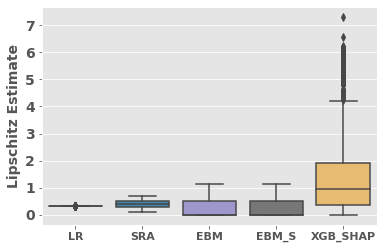

In [102]:
sns.boxplot(data=df_classic_expl)
plt.ylabel("Lipschitz Estimate",weight = 'bold',fontsize=14)
plt.xticks(weight = 'bold',fontsize=11,rotation=0)
plt.yticks(weight = 'bold',fontsize=14)
plt.savefig('Stability_HelocFico_hideen1_1E_2.png')
plt.show()

In [104]:
df_classic_output.columns = ['LR', 'SRA', 'EBM', 'EBM_S', 'XGB_SHAP']

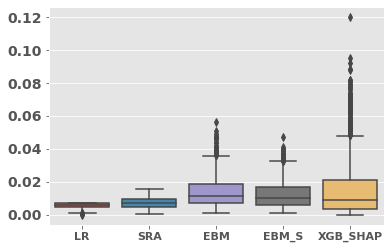

In [108]:
sns.boxplot(data=df_classic_output)
#plt.ylabel("Output Change",weight = 'bold',fontsize=14)
plt.xticks(weight = 'bold',fontsize=11,rotation=0)
plt.yticks(weight = 'bold',fontsize=14)
plt.savefig('Stability_OutputChange_HelocFico_hideen1_1E_2.png')
plt.show()